In [1]:
import cmlreaders as cml
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings; warnings.simplefilter('ignore')
pd.options.display.max_columns=None
pd.options.display.max_rows=100
from IPython.display import display, Markdown, HTML
import pandas_to_pybeh as pb
from tqdm import tqdm_notebook as lol
import time
import scipy
import rep_pybeh as rpb
from plotting import *
error_bars ={'elinewidth':1.5, 'capsize':3, 'capthick':1.5}

data_set = 'hospital'



## Hospital Data Load

In [2]:
if data_set == 'hospital':
    evs = []
    data = cml.get_data_index(kind = 'r1'); data = data[data['experiment'] == 'RepFR1']
    for subject, df in data.groupby('subject'):
        for session in pd.unique(df['session']):
            r = cml.CMLReader(subject=subject, experiment='RepFR1', session=session)
            temp = r.load('task_events')
            evs.append(temp)
    evs = pd.concat(evs)
    evs = evs[evs.list != 0]
    print(evs.subject.unique())
    for sub, df in evs.groupby('subject'):
        if 25 in df.list.unique():
            print(sub)
            evs = evs[evs.subject!=sub]
    print(evs.subject.nunique())

['R1204T' 'R1501J' 'R1514E' 'R1516E' 'R1528E' 'R1531T' 'R1534D' 'R1547D'
 'R1556J' 'R1564J' 'R1566D' 'R1568E' 'R1579T' 'R1582E' 'R1584J' 'R1586T'
 'R1587J' 'R1589T' 'R1590T' 'R1593D' 'R1594E' 'R1596T' 'R1604J' 'R1610D'
 'R1611T' 'R1612E' 'R1613T' 'R1615T' 'R1618J' 'R1619T' 'R1621E' 'R1622T'
 'R1625T' 'R1627T' 'R1628E' 'R1642J']
R1501J
35


## Scalp Data Load

In [3]:
if data_set == 'scalp':
    evs = []
    data = cml.get_data_index(kind = 'ltp'); data = data[data['experiment'] == 'ltpRepFR']
    for subject, df in data.groupby('subject'):
        for session in pd.unique(df['session']):
            r = cml.CMLReader(subject=subject, experiment='ltpRepFR', session=session)
            temp = r.load('all_events')
            evs.append(temp)
    evs = pd.concat(evs)
    evs = evs[evs.list != 0]
    print(evs.subject.unique())

In [4]:
word_evs = evs[evs.type=='WORD']
word_evs = word_evs.loc[word_evs.repeats != -999]
rec_evs = evs[evs.type=='REC_WORD']

count = 0
for i, df in evs.groupby('subject'):
    count += len(df.session.unique())
print('n = ' + str(len(evs.subject.unique()))+ ' with ' + str(count) + ' sessions' )

single_pres = word_evs.drop_duplicates(subset=['subject', 'session', 'list', 'item_name'])

repfr1 = single_pres.groupby(['subject', 'session', 'list']).recalled.mean().groupby(['subject', 'session']).mean().groupby(['subject']).mean().reset_index()
repfr1['exp'] = pd.Series('RepFR1', index = repfr1.index)
repfr1.mean()

n = 35 with 74 sessions


recalled    0.336171
dtype: float64

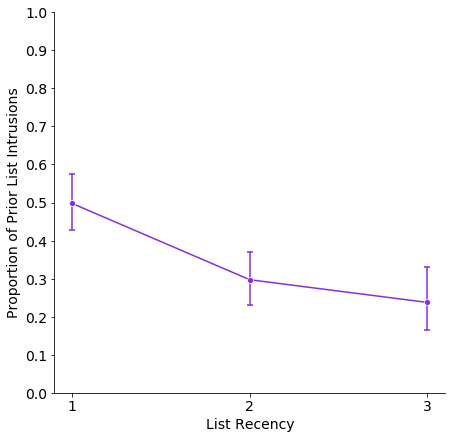

In [5]:
rec_evs['PLI'] = (rec_evs.intrusion>0).astype(int)
rec_evs['ELI'] = (rec_evs.intrusion<0).astype(int)

# plt.figure(figsize=(9, 6))
# sns.barplot(data=rec_evs[rec_evs.repeats>0].reset_index(), y='is_intrusion', x='repeats', color='dodgerblue', ci=95, capsize = .05, errwidth=2)
# plt.xlabel('# of Presentations', fontsize=16)
# plt.ylabel('Intrusion Rate', fontsize=16)
# plt.show()

pli = rec_evs[rec_evs.PLI == 1]
pli=pli[pli['list'] != 26]
pli=pli[pli['list'] > 5]
list_pli = pli.groupby(['subject', 'session', 'intrusion']).sum()
list_pli['prop'] = list_pli.PLI / pli.groupby(['subject', 'session']).PLI.sum()
list_pli.reset_index(inplace=True)
pli_curve = list_pli[list_pli.intrusion < 4]

sub_mean = pli_curve.groupby(['subject', 'intrusion']).prop.mean()
sub_mean
grand_mean = sub_mean.groupby(['intrusion']).mean()
sub_mean = sub_mean.reset_index().set_index('intrusion')
sub_mean['grand_mean'] = grand_mean
sub_mean['adjustment'] = sub_mean.grand_mean - sub_mean.prop

plis = pli_curve.set_index(['subject', 'intrusion', 'session'])
sub_mean = sub_mean.reset_index().set_index(['subject', 'intrusion'])

plis['adj_prop'] = plis.prop + sub_mean.adjustment
plis.reset_index(inplace=True)



set_axes(yticks = np.arange(0,1.1,.1), xticks = np.arange(1,4), ylim = [0,1])

# sns.lineplot(data=plis, x = 'intrusion', y = 'adj_prop', err_style = 'bars', ci = 95, marker = 'o', color = 'black', err_kws=error_bars)
sns.lineplot(data=plis, x = 'intrusion', y = 'prop', err_style = 'bars', ci = 95, marker = 'o', color = 'blueviolet', err_kws=error_bars)


plt.xlabel('List Recency')
plt.ylabel('Proportion of Prior List Intrusions')
plt.savefig(data_set+'_figs/plis.pdf')

In [6]:
intru = rec_evs.groupby(['subject', 'session', 'list'])['PLI','ELI'].sum().groupby(['subject', 'list']).mean()
intru.reset_index(inplace = True)
intru = intru[~intru.list.isin([0, 26])]
average_  = intru.groupby(['subject']).mean().mean()
average_

list    10.400000
PLI      0.439627
ELI      0.441162
dtype: float64

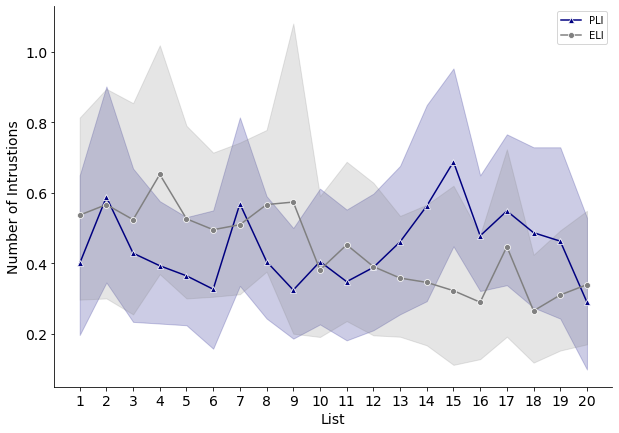

In [7]:
set_axes(figsize = (10,7), xticks = np.arange(1,26))
sns.lineplot(data=intru, x = 'list', y = 'PLI', ci = 95, label = 'PLI', color = 'navy', marker = '^')
# sns.lineplot(data=intru, x = 'list', y = 'PLI', ci = 95, hue = 'subject', alpha=0.5)
sns.lineplot(data=intru, x = 'list', y = 'ELI', ci = 95, label = 'ELI', color = 'gray', marker = 'o')
plt.xlabel('List')
plt.ylabel('Number of Intrustions')
# plt.legend()
plt.savefig(data_set+'_figs/PLIvsELI.pdf')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

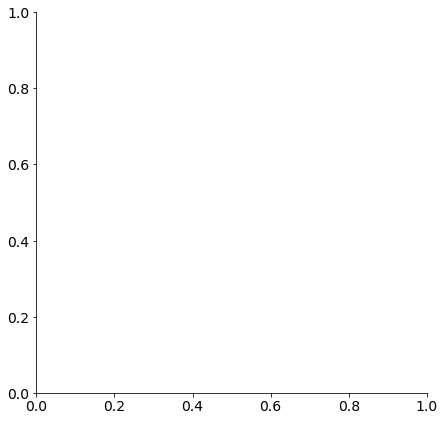

In [8]:
word_evs = evs[evs.type=='WORD']
word_evs = word_evs.loc[word_evs.repeats != -999]
rec_evs = evs[evs.type=='REC_WORD']

rec_evs = rec_evs[rec_evs.repeats != -999]
rec_wrds = rec_evs[rec_evs.list != 26]
ifr_counts = rec_wrds.groupby(['subject', 'session', 'repeats'])['item_num'].count().rename('num_recs')
ifr_counts = ifr_counts.reset_index().groupby(['subject', 'repeats']).mean().drop('session', axis = 1)
ifr_counts = ifr_counts.divide(75).reset_index()
threes = ifr_counts[ifr_counts.repeats == 3].num_recs.divide(2)
ifr_counts.at[threes.index, 'num_recs'] = threes

ffr = rec_evs[rec_evs.list == 26]
ffr_counts = ffr.groupby(['subject', 'session', 'repeats'])['item_num'].count().rename('num_recs')
ffr_counts = ffr_counts.reset_index().groupby(['subject', 'repeats']).mean().drop('session', axis = 1)
ffr_counts = ffr_counts.divide(75).reset_index()
threes = ffr_counts[ffr_counts.repeats == 3].num_recs.divide(2)
ffr_counts.at[threes.index, 'num_recs'] = threes
ffr_counts
counts = ffr_counts
counts['IFR'] = ifr_counts.num_recs
counts.rename(columns={'num_recs':'FFR', 'repeats':'Presentations'}, inplace=True)
set_axes()
# sns.barplot(data=counts, x = 'repeats', y= 'ffr', palette = ['navy', 'navy', 'navy'])
# sns.barplot(data=counts, x = 'repeats', y= 'ifr', palette = ['gray', 'gray', 'gray'])


# sns.regplot(data = counts[counts.repeats == 1], x = 'ifr', y = 'ffr', label = '1')
# sns.regplot(data = counts[counts.repeats == 2], x = 'ifr', y = 'ffr', label = '2')
# sns.regplot(data = counts[counts.repeats == 3], x = 'ifr', y = 'ffr', label = '3')
# plt.ylim([0,1])
# plt.legend(title = 'Presentations')
counts = pd.melt(counts, id_vars="Presentations", var_name="Recall Type", value_name="Recall Proportion")
counts = counts[counts['Recall Type'] != 'subject']
sns.barplot(data=counts, x = 'Presentations', y= 'Recall Proportion', hue = 'Recall Type')
plt.savefig('ffr_ifr_recall_by_rep.pdf')

In [9]:
first_crp = []
for i, df in word_evs.groupby(['subject', 'session', 'list']):
    try:
#         df = df.loc[df.repeats == 3]
        df = df.drop_duplicates('item_num')
        positions = len(df.item_num.unique())
        df['serialpos'] = pd.Series(range(positions), index = df.index)
        first_crp.append(df)
    except:
        a, b, c = i
        print('Subject ' + a + ' session ' + str(b) + ' failed')
first_crp = pd.concat(first_crp)


In [10]:
last_crp = []
for i, df in word_evs.groupby(['subject', 'session', 'list']):
    try:
        df = df.drop_duplicates('item_num', keep='last')
#         df = df.loc[df.repeats == 3]

        positions = len(df.item_num.unique())
        df['serialpos'] = pd.Series(range(positions), index = df.index)
        last_crp.append(df)
    except:
        a, b, c = i
        print('Subject ' + a + ' session ' + str(b) + ' failed')
last_crp = pd.concat(last_crp)

### First Presentation Only CRP

ValueError: cannot reindex from a duplicate axis

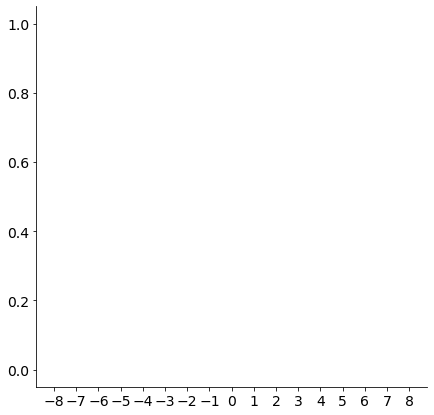

In [12]:
first_beh = first_crp.append(rec_evs)
first_agg = []

for i, df in first_beh.groupby('subject'):
    first_agg.append(pb.pd_crp(df, itemno_column='item_num', list_index=['subject', 'session', 'list'], lag_num=8))

first_agg = pd.concat(first_agg)
error_bars ={'elinewidth':1.5, 'capsize':3, 'capthick':1.5}
fig, ax = plt.subplots(figsize=(7, 7))
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)
_ = plt.xticks(range(-8, 9), fontsize = 14)
_ = plt.yticks(fontsize = 14)
g = sns.lineplot(data=first_agg.loc[first_agg['lag'] < 0], x='lag', y='prob', err_style = 'bars', ci = 95, marker = 'o', color = 'black', err_kws=error_bars)
g = sns.lineplot(data=first_agg.loc[first_agg['lag'] > 0], x='lag', y='prob', err_style = 'bars', ci = 95, marker = 'o', color = 'black', err_kws=error_bars)
_ = plt.xlabel('Lag', fontsize = 14)
_ = plt.ylabel('Conditional Response Probability', fontsize = 14)
_ = plt.ylim([0, 0.4])
plt.savefig(data_set+'first_pres_crp.pdf')

In [11]:
sem_crp = []
n_bins = 10
sim_mat = pd.read_csv('similarity_matrix.csv', index_col = 0)
first_beh = first_beh[first_beh.list != 26]

sim_mat

# for i, df in first_beh.groupby('subject'):
#     sem_crp.append(pb.pd_sem_crp(df, itemno_column='item_num', sem_sims = sim_mat, list_index=['subject', 'session', 'list']))
sem_crp = first_beh.groupby(['subject']).apply(lambda x: pb.pd_sem_crp(x, itemno_column='item_num', list_index=['subject', 'session', 'list'], sem_sims = sim_mat, n_bins=n_bins)).reset_index()
# test = first_beh[first_beh.subject == 'LTP441']
# test = test[test.session == 0]
# test.set_index(['subject', 'session', 'list'], inplace = True)
# np.sort(first_beh.item_num.unique())
set_axes(xticks = np.arange(0,11))
sns.lineplot(data = sem_crp, x = 'sem_bin', y = 'prob',err_style = 'bars', ci = 95, marker = 'o', color = 'black', err_kws=error_bars)

NameError: name 'first_beh' is not defined

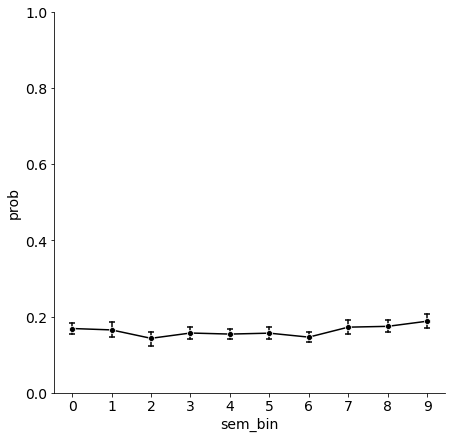

In [12]:
sem_crp = []
n_bins = 10
sim_mat = pd.read_csv('similarity_matrix.csv', index_col = 0)
last_beh = last_crp.append(rec_evs)
last_beh = last_beh[last_beh.list != 26]
last_beh['item_num'] = last_beh.item_num-2
sim_mat

# for i, df in first_beh.groupby('subject'):
#     sem_crp.append(pb.pd_sem_crp(df, itemno_column='item_num', sem_sims = sim_mat, list_index=['subject', 'session', 'list']))
sem_crp = last_beh.groupby(['subject']).apply(lambda x: pb.pd_sem_crp(x, itemno_column='item_num', list_index=['subject', 'session', 'list'], sem_sims = sim_mat, n_bins=n_bins)).reset_index()
# test = first_beh[first_beh.subject == 'LTP441']
# test = test[test.session == 0]
# test.set_index(['subject', 'session', 'list'], inplace = True)
# np.sort(first_beh.item_num.unique())
set_axes(xticks = np.arange(0,11), ylim=[0,1])
sns.lineplot(data = sem_crp, x = 'sem_bin', y = 'prob',err_style = 'bars', ci = 95, marker = 'o', color = 'black', err_kws=error_bars)

### Last Presentation Only CRP

ValueError: cannot reindex from a duplicate axis

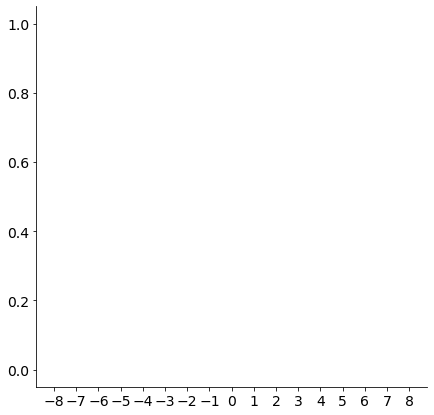

In [13]:
last_beh = last_crp.append(rec_evs)
last_agg = []
for i, df in last_beh.groupby('subject'):
    last_agg.append(pb.pd_crp(df, itemno_column='item_num', list_index=['subject', 'session', 'list'], lag_num=8))

last_agg = pd.concat(last_agg)
error_bars ={'elinewidth':1.5, 'capsize':3, 'capthick':1.5}
error_bars ={'elinewidth':1.5, 'capsize':3, 'capthick':1.5}
fig, ax = plt.subplots(figsize=(7, 7))
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)
_ = plt.xticks(range(-8, 9), fontsize = 14)
_ = plt.yticks(fontsize = 14)
g = sns.lineplot(data=last_agg.loc[last_agg['lag'] < 0], x='lag', y='prob', err_style = 'bars', ci = 95, marker = 'o', color = 'black', err_kws=error_bars)
g = sns.lineplot(data=last_agg.loc[last_agg['lag'] > 0], x='lag', y='prob', err_style = 'bars', ci = 95, marker = 'o', color = 'black', err_kws=error_bars)
_ = plt.xlabel('Lag', fontsize = 14)
_ = plt.ylabel('Conditional Response Probability', fontsize = 14)
_ = plt.ylim([0, 0.35])
# plt.savefig(data_set+'last_pres_crp.pdf')

In [ ]:
last_agg = []
subjects = []
subjects = last_beh.subject.unique()
temp_fact = pd.DataFrame(index = subjects)

for i, df in first_beh.groupby('subject'):
    temp_fact.at[i, 'first_temp'] = pb.pd_temp_fact(df, itemno_column='item_num', list_index=['subject', 'session', 'list'])

for i, df in last_beh.groupby('subject'):
    temp_fact.at[i, 'last_temp'] = pb.pd_temp_fact(df, itemno_column='item_num', list_index=['subject', 'session', 'list'])

temp_fact['temp'] = facts['temp_fact'].astype(float)

for i, df in first_beh.groupby('subject'):
    temp_fact.at[i, 'recall'] = df.recalled.mean()
temp_fact.dropna(inplace=True)

# first_r, first_p = scipy.stats.pearsonr(temp_fact.first_temp, temp_fact.recall)
# last_r, last_p = scipy.stats.pearsonr(temp_fact.last_temp, temp_fact.recall)
r, p = scipy.stats.pearsonr(temp_fact.temp, temp_fact.recall)
# print('p = ', first_p, 'r = ', first_r)
print('p = ', p, 'r = ', r)
# print('p = ', last_p, 'r = ', last_r)
fig, ax = plt.subplots(figsize=(7, 7))
error_bars ={'elinewidth':2, 'capsize':3, 'capthick':2}
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)


# sns.regplot(data = temp_fact, x = 'first_temp', y = 'recall', label = 'First Presentation')
# sns.regplot(data = temp_fact, x = 'last_temp', y = 'recall', label = 'Last Presentation')
sns.regplot(data = temp_fact, x = 'temp', y = 'recall', label = 'My Presentation', color = 'black')
# plt.legend()
# type(temp_fact.first_temp[0])

In [ ]:
first_spc = first_crp.groupby(['subject', 'session', 'list', 'serialpos']).mean().reset_index().groupby(['subject', 'session','serialpos']).mean().reset_index().groupby(['subject','serialpos']).mean().reset_index()

In [ ]:
first_spc = first_spc.loc[~first_spc.subject.isin(['R1516E', 'R1531T'])]  
plt.figure(figsize=(9, 9))
g = sns.lineplot(data = first_spc, x = 'serialpos', y = 'recalled', err_style = 'band', ci = 95, marker = 'o', color = 'navy')#, err_kws=error_bars)
_ = plt.xticks(range(12))
plt.title('Serial Position Curve First Presentation, Reset Serial Positions', fontsize = 18)
plt.xlabel('Serial Position', fontsize = 14)
plt.ylabel('Recall Proportion', fontsize = 14)
plt.savefig('spc_first_reset')

In [ ]:
last_spc = last_crp.groupby(['subject', 'session', 'list', 'serialpos']).mean().reset_index().groupby(['subject', 'session','serialpos']).mean().reset_index().groupby(['subject','serialpos']).mean().reset_index()

In [ ]:
last_spc = last_spc.loc[~last_spc.subject.isin(['R1516E', 'R1531T'])]    
plt.figure(figsize=(9, 9))

g = sns.lineplot(data = last_spc, x = 'serialpos', y = 'recalled', err_style = 'band', ci = 95, marker = 'o', color = 'navy')#, err_kws=error_bars)
_ = plt.xticks(range(12))
plt.title('Serial Position Curve Last Presentation, Reset Serial Positions', fontsize = 18)
plt.xlabel('Serial Position', fontsize = 14)
plt.ylabel('Recall Proportion', fontsize = 14)
plt.savefig('spc_last_reset')

### Serial Position Curve

ValueError: cannot reindex from a duplicate axis

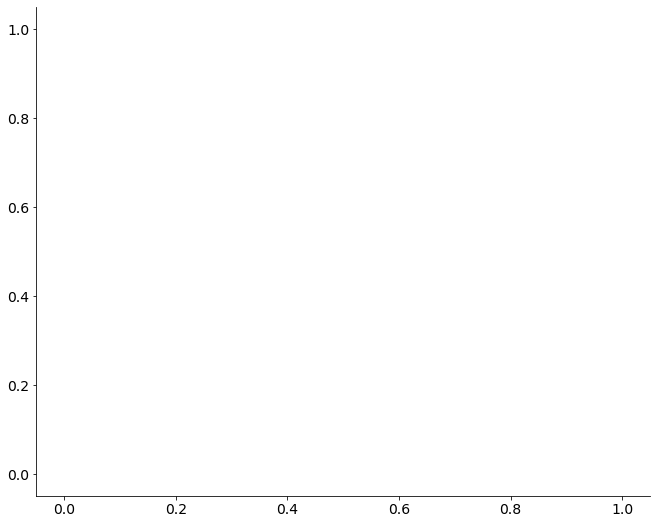

In [14]:
fig, ax = plt.subplots(figsize=(11, 9))

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)
one_spc = word_evs.loc[word_evs.repeats == 1]

_ = plt.xticks(fontsize = 14)
_ = plt.yticks(fontsize = 14)

g = sns.lineplot(data = one_spc, x = 'serialpos', y = 'recalled', err_style = 'band', ci = 95, marker = 'o', color = 'navy', label = 'Once Presented')
one_spc = one_spc.groupby(['subject', 'session', 'list', 'serialpos']).mean().reset_index().groupby(['subject', 'session','serialpos']).mean().reset_index().groupby(['subject','serialpos']).mean().reset_index()
two_spc = word_evs.loc[word_evs.repeats.isin([2])]
two_spc = two_spc.groupby(['subject', 'session', 'list', 'serialpos']).mean().reset_index().groupby(['subject', 'session','serialpos']).mean().reset_index().groupby(['subject','serialpos']).mean().reset_index()
g = sns.lineplot(data = two_spc, x = 'serialpos', y = 'recalled', err_style = 'band', ci = 95, marker = 's', color = 'gray', label = 'Twice Presented')
three_spc = word_evs.loc[word_evs.repeats.isin([3])]
three_spc = three_spc.groupby(['subject', 'session', 'list', 'serialpos']).mean().reset_index().groupby(['subject', 'session','serialpos']).mean().reset_index().groupby(['subject','serialpos']).mean().reset_index()
g = sns.lineplot(data = three_spc, x = 'serialpos', y = 'recalled', err_style = 'band', ci = 95, marker = '^', color = 'black', label = 'Thrice Presented')
plt.xlabel('Serial Position', fontsize = 14)
plt.ylabel('Recall Proportion', fontsize = 14)
plt.xticks(range(27))
plt.ylim([0, 1])
plt.legend(loc="best")
# plt.tit# # le('Serial Position Curve Including All Repetitions', fontsize = 18)
plt.savefig(data_set +'_spc.pdf')

### Lag-CRP

In [15]:
sub_crps = []
crps = []
num_lags = 8
for i, beh in lol(evs.groupby('subject')):
    sess_crps = []
    for j, df in beh.groupby('session'):
        df = rpb.get_act_spos(df)
        sess_crp = rpb.crp(df, num_lags = num_lags, list_length = 27)
        sess_crps.append(sess_crp)
    sub_crp = pd.concat(sess_crps).groupby('lag').mean()
    crps.append(sub_crp)
crps = pd.concat(crps)
crps.reset_index(inplace = True)


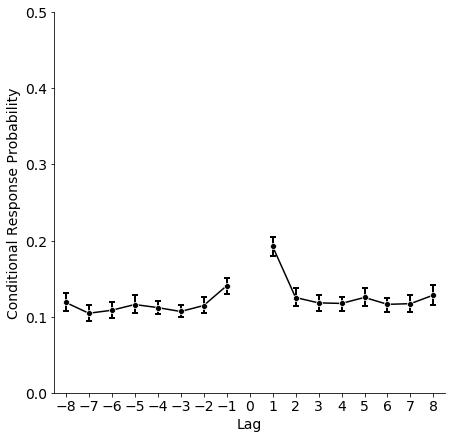

In [16]:
fig, ax = plt.subplots(figsize=(7, 7))
error_bars ={'elinewidth':2, 'capsize':3, 'capthick':2}
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

g = sns.lineplot(data = crps[crps.lag>0], x = 'lag', y = 'prob', err_style = 'bars', ci = 95, marker = 'o', color = 'black', err_kws=error_bars)
g = sns.lineplot(data = crps[crps.lag<0], x = 'lag', y = 'prob', err_style = 'bars', ci = 95, marker = 'o', color = 'black', err_kws=error_bars)

# sns.pointplot(data = , x = 'lag', y = 'prob')
_ = plt.xticks(range(-num_lags, num_lags+1), fontsize = 14)
_ = plt.yticks(fontsize = 14)
# _ = plt.grid()
_ = plt.xlim(-num_lags - 0.5, num_lags + 0.5)


# _ = plt.title('Massed Lag-CRP (Hospital RepFR1)', fontsize = 18)
_ = plt.ylabel('Conditional Response Probability', fontsize = 14)
_ = plt.xlabel('Lag', fontsize = 14)
_ = plt.ylim([0, 0.5])
plt.savefig(data_set +'_crp.pdf')

### Minimum Lag-CRP

In [17]:
sub_crps = []
min_crps = []
num_lags = 8
for i, beh in lol(evs.groupby('subject')):
    sess_crps = []
    for j, df in beh.groupby('session'):
        df = rpb.get_act_spos(df)
        sess_crp = rpb.min_crp(df, num_lags = num_lags, list_length = 27, halfornah = 'nah')
        sess_crps.append(sess_crp)
    sub_crp = pd.concat(sess_crps).groupby('lag').mean()
    min_crps.append(sub_crp)
min_crps = pd.concat(min_crps)
min_crps.reset_index(inplace = True)

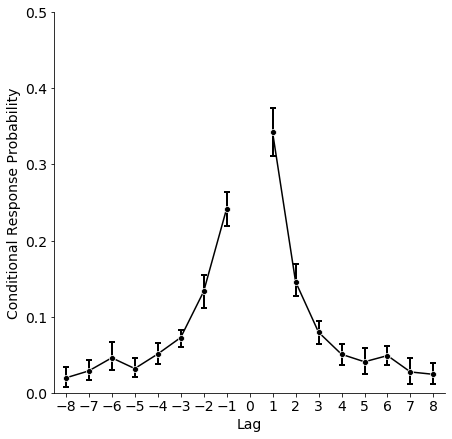

In [18]:
fig, ax = plt.subplots(figsize=(7, 7))
error_bars ={'elinewidth':2, 'capsize':3, 'capthick':2}
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)


g = sns.lineplot(data = min_crps[min_crps.lag > 0], x = 'lag', y = 'prob', err_style = 'bars', ci = 95, marker = 'o', color = 'black', err_kws=error_bars)
g = sns.lineplot(data = min_crps[min_crps.lag < 0], x = 'lag', y = 'prob', err_style = 'bars', ci = 95, marker = 'o', color = 'black', err_kws=error_bars)
_ = plt.xticks(range(-num_lags, num_lags+1), fontsize = 14)
_ = plt.yticks(fontsize = 14)
# _ = plt.grid()
_ = plt.xlim(-num_lags - 0.5, num_lags + 0.5)

# _ = plt.title('Massed Lag-CRP (Hospital RepFR1)', fontsize = 18)
_ = plt.ylabel('Conditional Response Probability', fontsize = 14)
_ = plt.xlabel('Lag', fontsize = 14)
_ = plt.ylim([0, 0.5])
plt.savefig(data_set +'_min_crp.pdf')

In [43]:
sub_crps = []
min_crps = []
num_lags = 8
for i, beh in lol(evs.groupby('subject')):
    sess_crps = []
    for j, df in beh.groupby('session'):
        df = rpb.get_act_spos(df)
        sess_crp = rpb.min_crp(df, num_lags = num_lags, list_length = 27, halfornah = 'yah')
        sess_crps.append(sess_crp)
    sub_crp = pd.concat(sess_crps).groupby('lag').mean()
    min_crps.append(sub_crp)
min_crps = pd.concat(min_crps)
min_crps.reset_index(inplace = True)

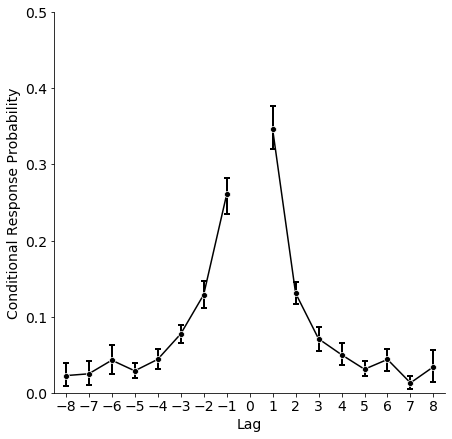

In [44]:
fig, ax = plt.subplots(figsize=(7, 7))
error_bars ={'elinewidth':2, 'capsize':3, 'capthick':2}
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)


g = sns.lineplot(data = min_crps[min_crps.lag > 0], x = 'lag', y = 'prob', err_style = 'bars', ci = 95, marker = 'o', color = 'black', err_kws=error_bars)
g = sns.lineplot(data = min_crps[min_crps.lag < 0], x = 'lag', y = 'prob', err_style = 'bars', ci = 95, marker = 'o', color = 'black', err_kws=error_bars)
_ = plt.xticks(range(-num_lags, num_lags+1), fontsize = 14)
_ = plt.yticks(fontsize = 14)
# _ = plt.grid()
_ = plt.xlim(-num_lags - 0.5, num_lags + 0.5)

# _ = plt.title('Massed Lag-CRP (Hospital RepFR1)', fontsize = 18)
_ = plt.ylabel('Conditional Response Probability', fontsize = 14)
_ = plt.xlabel('Lag', fontsize = 14)
_ = plt.ylim([0, 0.5])
plt.savefig(data_set +'_half_min_crp.pdf')

In [ ]:
sub_crps = []
num_lags = 30
for sub, beh in lol(evs.groupby('subject')):
    subs_crps = []
    for sess, df in beh.groupby('session'):
        rec_evs = df[df.list == 26]
        rec_evs = rec_evs[rec_evs.type == 'REC_WORD'].reset_index()
        word_evs = df[df.type == 'WORD']
        word_evs.list = pd.Series(26, index = word_evs.index)
        word_evs.reset_index(inplace = True)
        word_evs.serialpos = pd.Series(range(0, len(word_evs) + 1))
        recs = rpb.get_act_spos(word_evs.append(rec_evs))
        sess_crps = rpb.crp(recs, num_lags = num_lags, list_length = 675)
        sess_crp = sess_crps.groupby('lag').mean()
        subs_crps.append(sess_crp)
    subs_crps = pd.concat(subs_crps)
    sub_crps.append(subs_crps)
sub_crps = pd.concat(sub_crps)
sub_crps = sub_crps.reset_index()

In [ ]:
fig, ax = plt.subplots(figsize=(17, 7))
error_bars ={'elinewidth':2, 'capsize':3, 'capthick':2}
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)


g = sns.lineplot(data = sub_crps[sub_crps.lag > 0], x = 'lag', y = 'prob', err_style = 'bars', ci = 95, marker = 'o', color = 'black', err_kws=error_bars)
g = sns.lineplot(data = sub_crps[sub_crps.lag < 0], x = 'lag', y = 'prob', err_style = 'bars', ci = 95, marker = 'o', color = 'black', err_kws=error_bars)
_ = plt.xticks(range(-num_lags, num_lags+1), fontsize = 11)
_ = plt.yticks(fontsize = 14)
# _ = plt.grid()
_ = plt.xlim(-num_lags - 0.5, num_lags + 0.5)

# _ = plt.title('Massed Lag-CRP (Hospital RepFR1)', fontsize = 18)
_ = plt.ylabel('Conditional Response Probability', fontsize = 14)
_ = plt.xlabel('Lag', fontsize = 14)
_ = plt.ylim([0, 0.5])

In [27]:
sub_crps = []
num_lags = 30
for sub, beh in lol(evs.groupby('subject')):
    subs_crps = []
    for sess, df in beh.groupby('session'):
        rec_evs = df[df.list == 26]
        rec_evs = rec_evs[rec_evs.type == 'REC_WORD'].reset_index()
        word_evs = df[df.type == 'WORD']
        word_evs.list = pd.Series(26, index = word_evs.index)
        word_evs.reset_index(inplace = True)
        word_evs.serialpos = pd.Series(range(0, len(word_evs) + 1))
        recs = rpb.get_act_spos(word_evs.append(rec_evs))
        sess_crps = rpb.min_crp(recs, num_lags = num_lags, list_length = 675)
        sess_crp = sess_crps.groupby('lag').mean()
        subs_crps.append(sess_crp)
    subs_crps = pd.concat(subs_crps)
    sub_crps.append(subs_crps)
sub_crps = pd.concat(sub_crps)
sub_crps = sub_crps.reset_index()
sub_crps = sub_crps.replace([np.inf, -np.inf], 0)

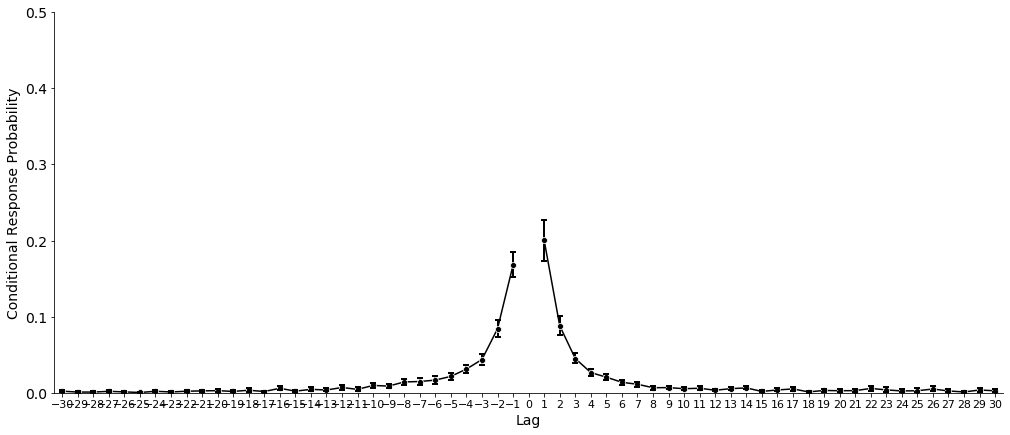

In [28]:
fig, ax = plt.subplots(figsize=(17, 7))
error_bars ={'elinewidth':2, 'capsize':3, 'capthick':2}
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)


g = sns.lineplot(data = sub_crps[sub_crps.lag > 0], x = 'lag', y = 'prob', err_style = 'bars', ci = 95, marker = 'o', color = 'black', err_kws=error_bars)
g = sns.lineplot(data = sub_crps[sub_crps.lag < 0], x = 'lag', y = 'prob', err_style = 'bars', ci = 95, marker = 'o', color = 'black', err_kws=error_bars)
_ = plt.xticks(range(-num_lags, num_lags+1), fontsize = 11)
_ = plt.yticks(fontsize = 14)
# _ = plt.grid()
_ = plt.xlim(-num_lags - 0.5, num_lags + 0.5)

# _ = plt.title('Massed Lag-CRP (Hospital RepFR1)', fontsize = 18)
_ = plt.ylabel('Conditional Response Probability', fontsize = 14)
_ = plt.xlabel('Lag', fontsize = 14)
_ = plt.ylim([0, 0.5])

In [29]:
%matplotlib inline
import cmlreaders as cml
import pandas_to_pybeh as pb
import numpy as np
import seaborn as sns
import pandas as pd
from plotting import *
error_bars ={'elinewidth':1.5, 'capsize':3, 'capthick':1.5}

In [30]:
all_repfr_events = cml.CMLReader.load_events(experiments='ltpRepFR')


In [31]:
evs = all_repfr_events[all_repfr_events.list != 0]
word_evs = evs[evs.type=='WORD']
word_evs = word_evs.loc[word_evs.repeats != -999]
rec_evs = evs[evs.type=='REC_WORD']

first_crp = []
for i, df in word_evs.groupby(['subject', 'session']):
    try:
#         df = df.loc[df.repeats == 3]
        df = df.drop_duplicates('item_num')
        positions = len(df.item_num.unique())
        df['serialpos'] = pd.Series(range(positions), index = df.index)
        first_crp.append(df)
    except:
        a, b, c = i
        print('Subject ' + a + ' session ' + str(b) + ' failed')
first_crp = pd.concat(first_crp)

In [32]:
events = first_crp.append(rec_evs)

In [33]:
# replace item nums so they are consistent across subjects
item_col = 'item_name'
item_num_col = 'item_num'
item_num_df = events.drop_duplicates(subset=item_col, ignore_index=True
                                    )[item_col].reset_index().rename(columns={'index': item_num_col})
item_num_df[item_num_col] = item_num_df[item_num_col] + 1
events_new = events.merge(item_num_df, on=item_col, suffixes=('', '_new'))

In [34]:
import gensim.downloader
word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')

In [35]:
def word_similarity(df, col1, col2, keyed_vector=None):
    try:
        similarity = keyed_vector.similarity(df[col1].lower(), df[col2].lower())
        return similarity
    except:
        return np.nan

In [36]:
# get all pairs of items
items = item_num_df[item_col].values
sem_sim_df = pd.MultiIndex.from_product([items, items], names=[item_col+'_1', item_col+'_2']).to_frame(index=False)

In [37]:
# compute similarity of all pairs
sem_sim_df['similarity'] = sem_sim_df.apply(word_similarity, 
               axis=1, col1=item_col+'_1', 
               col2=item_col+'_2', 
               keyed_vector=word2vec_vectors)

In [38]:
sem_sim_num_df = sem_sim_df.merge(
    item_num_df, left_on=item_col+'_1', right_on=item_col).merge(
    item_num_df, left_on=item_col+'_2', right_on=item_col, suffixes=('_1', '_2'))

In [39]:
sem_sims = pd.pivot_table(sem_sim_num_df, 
                          index=item_num_col+'_1', 
                          columns=item_num_col+'_2', 
                          values='similarity', dropna=False)

In [40]:
sem_sims

item_num_2,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408
item_num_1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.093802,0.078450,0.057159,0.034051,0.070729,0.073239,0.112888,0.049081,0.047837,0.087213,0.075100,0.111669,0.092330,0.084557,0.035215,0.079404,0.033176,0.081813,0.190246,0.061542,0.046479,0.129079,0.069860,0.121170,0.247532,0.127832,0.046331,0.153190,0.100373,0.111562,0.068365,0.220919,0.074346,0.095992,-0.017065,0.017808,0.074100,0.087563,0.031497,0.012484,0.132817,0.139394,0.017040,0.036882,0.043692,0.197649,0.123504,0.220861,0.022238,0.090659,0.077261,0.044874,0.124483,0.108078,0.065973,0.076800,0.022154,0.072421,0.120604,0.080647,0.026405,0.065005,0.120292,0.098087,0.091181,0.098791,0.116521,0.070825,0.118463,0.189583,0.067800,0.098446,0.086727,0.099991,0.149675,0.088799,0.164638,0.055023,0.000326,0.075055,0.122566,0.084033,0.140518,0.047341,0.112734,0.123453,0.054817,0.107630,0.075847,0.068843,0.099486,0.091019,0.094318,0.128846,0.131670,0.071630,0.058932,0.061653,0.109050,0.072995,0.027638,0.044692,-0.006709,0.160628,0.108915,0.050819,0.075706,0.067253,0.106642,0.057651,0.049123,0.083950,0.242992,0.167320,0.065331,0.085429,0.224097,0.038478,0.027394,0.121712,0.137265,0.154588,0.110776,0.070219,0.048739,0.190545,0.025100,-0.006067,-0.019425,0.095849,-0.033854,0.055858,0.066734,0.015025,0.094497,0.074470,0.039037,0.162578,0.080357,0.041013,0.084680,0.106962,0.074919,0.057934,0.109275,0.054640,0.008808,0.164628,0.102632,0.033960,0.127014,0.061650,0.070166,0.004239,0.127744,0.113053,0.069662,0.008888,0.037837,0.049955,0.155700,0.068492,0.024434,0.057122,0.107481,0.115326,0.143129,0.120076,0.120621,0.097232,0.136720,0.113047,0.165690,0.121240,0.041112,0.047542,0.017576,0.107959,0.030155,0.183774,0.153080,0.030733,0.020962,0.050406,0.203948,0.016898,0.039035,0.121753,0.138585,0.121805,0.047200,0.080433,0.035266,0.041753,0.119454,0.077249,0.119125,-0.005180,0.134139,0.132565,0.195533,0.057122,0.020903,0.172374,0.116613,0.013263,0.176573,0.250192,0.144456,0.073953,0.092509,0.141607,0.137250,0.101058,0.120738,0.127322,0.098427,0.115417,0.103674,0.151748,-0.042922,0.190247,0.071391,0.081462,0.130036,0.0

In [43]:
ffr = []
sub_crps = []

for sub, beh in lol(events_new.groupby('subject')):
    subs_crps = []
    for sess, df in beh.groupby('session'):
        rec_evs = df[df.list == 26]
        rec_evs = rec_evs[rec_evs.type == 'REC_WORD'].reset_index()
        word_evs = df[df.type == 'WORD']
        word_evs.list = pd.Series(26, index = word_evs.index)
        word_evs.reset_index(inplace = True)
        word_evs.serialpos = pd.Series(range(0, len(word_evs) + 1))
        word_evs.append(rec_evs)

,index,answer_correct,distractor,distractor_answer,eegfile,eegoffset,eogArtifact,experiment,intruded,intrusion,is_repeat,item_name,item_num,list,montage,msoffset,mstime,phase,protocol,recalled,rectime,repeats,serialpos,session,subject,type,item_num_new
0,0,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP441/experiments/ltp...,593594,0,ltpRepFR,0,-999,0,BOMB,23,26,0,-1,1614014077265,,ltp,1,-999,1,0,0,LTP441,WORD,1
1,155,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP441/experiments/ltp...,598474,0,ltpRepFR,0,-999,0,GLOVE,106,26,0,-1,1614014079648,,ltp,1,-999,3,1,0,LTP441,WORD,2
2,315,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP441/experiments/ltp...,603457,0,ltpRepFR,0,-999,0,LACE,137,26,0,-1,1614014082081,,ltp,1,-999,3,2,0,LTP441,WORD,3
3,474,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP441/experiments/ltp...,608339,0,ltpRepFR,0,-999,0,BOWL,26,26,0,-1,1614014084465,,ltp,1,-999,3,3,0,LTP441,WORD,4
4,645,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP441/experiments/ltp...,613458,2,ltpRepFR,0,-999,0,SPHINX,244,26,0,-1,1614014086965,,ltp,1,-999,2,4,0,LTP441,WORD,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,50547,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP441/experiments/ltp...,8090623,0,ltpRepFR,1,-999,0,SCHOOL,208,26,0,-1,1614017738187,,ltp,1,-999,2,295,0,LTP441,WORD,296
296,50725,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP441/experiments/ltp...,8100588,0,ltpRepFR,1,-999,0,STRING,263,26,0,-1,1614017743053,,ltp,1,-999,3,296,0,LTP441,WORD,297
297,50919,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP441/experiments/ltp...,8110520,2,ltpRepFR,1,-999,0,RAT,195,26,0,-1,1614017747903,,ltp,1,-999,2,297,0,LTP441,WORD,298
298,51103,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP441/experiments/ltp...,8145473,0,ltpRepFR,0,-999,0,SKI,223,26,0,-1,1614017764971,,ltp,0,-999,1,298,0,LTP441,WORD,299


,index,answer_correct,distractor,distractor_answer,eegfile,eegoffset,eogArtifact,experiment,intruded,intrusion,is_repeat,item_name,item_num,list,montage,msoffset,mstime,phase,protocol,recalled,rectime,repeats,serialpos,session,subject,type,item_num_new
0,8,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP442/experiments/ltp...,5770303,0,ltpRepFR,0,-999,0,BOMB,23,26,0,-1,1614613602052,,ltp,1,-999,3,0,0,LTP442,WORD,1
1,164,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP442/experiments/ltp...,1480862,0,ltpRepFR,21,-999,0,GLOVE,106,26,0,-1,1614611507448,,ltp,1,-999,3,1,0,LTP442,WORD,2
2,323,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP442/experiments/ltp...,425294,0,ltpRepFR,25,-999,0,LACE,137,26,0,-1,1614610991997,,ltp,1,-999,2,2,0,LTP442,WORD,3
3,483,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP442/experiments/ltp...,7439463,0,ltpRepFR,1,-999,0,BOWL,26,26,0,-1,1614614417130,,ltp,1,-999,3,3,0,LTP442,WORD,4
4,654,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP442/experiments/ltp...,976971,0,ltpRepFR,0,-999,0,SPHINX,244,26,0,-1,1614611261390,,ltp,1,-999,2,4,0,LTP442,WORD,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,52670,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP442/experiments/ltp...,4480555,0,ltpRepFR,11,-999,0,DRINK,76,26,0,-1,1614612972247,,ltp,1,-999,2,295,0,LTP442,WORD,308
296,52828,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP442/experiments/ltp...,4566671,0,ltpRepFR,0,-999,0,BARN,10,26,0,-1,1614613014299,,ltp,1,-999,1,296,0,LTP442,WORD,309
297,53009,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP442/experiments/ltp...,6602887,0,ltpRepFR,4,-999,0,THRONE,275,26,0,-1,1614614008616,,ltp,1,-999,2,297,0,LTP442,WORD,310
298,53186,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP442/experiments/ltp...,3633432,2,ltpRepFR,14,-999,0,SPOUSE,247,26,0,-1,1614612558583,,ltp,1,-999,3,298,0,LTP442,WORD,311


,index,answer_correct,distractor,distractor_answer,eegfile,eegoffset,eogArtifact,experiment,intruded,intrusion,is_repeat,item_name,item_num,list,montage,msoffset,mstime,phase,protocol,recalled,rectime,repeats,serialpos,session,subject,type,item_num_new
0,18,0,"[-999, -999, -999]",-999,,-1,-1,ltpRepFR,20,-999,0,BOMB,23,26,0,-1,1614880475803,,ltp,1,-999,3,0,0,LTP443,WORD,1
1,174,0,"[-999, -999, -999]",-999,,-1,-1,ltpRepFR,0,-999,0,GLOVE,106,26,0,-1,1614882399034,,ltp,1,-999,3,1,0,LTP443,WORD,2
2,333,0,"[-999, -999, -999]",-999,,-1,-1,ltpRepFR,20,-999,0,LACE,137,26,0,-1,1614880490321,,ltp,1,-999,3,2,0,LTP443,WORD,3
3,492,0,"[-999, -999, -999]",-999,,-1,-1,ltpRepFR,18,-999,0,BOWL,26,26,0,-1,1614880767213,,ltp,1,-999,1,3,0,LTP443,WORD,4
4,664,0,"[-999, -999, -999]",-999,,-1,-1,ltpRepFR,15,-999,0,SPHINX,244,26,0,-1,1614881284180,,ltp,1,-999,2,4,0,LTP443,WORD,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,52680,0,"[-999, -999, -999]",-999,,-1,-1,ltpRepFR,18,-999,0,DRINK,76,26,0,-1,1614880752496,,ltp,1,-999,1,295,0,LTP443,WORD,308
296,52838,0,"[-999, -999, -999]",-999,,-1,-1,ltpRepFR,11,-999,0,BARN,10,26,0,-1,1614881823098,,ltp,1,-999,3,296,0,LTP443,WORD,309
297,53018,0,"[-999, -999, -999]",-999,,-1,-1,ltpRepFR,0,-999,0,THRONE,275,26,0,-1,1614880972436,,ltp,1,-999,1,297,0,LTP443,WORD,310
298,53196,0,"[-999, -999, -999]",-999,,-1,-1,ltpRepFR,19,-999,0,SPOUSE,247,26,0,-1,1614880612691,,ltp,1,-999,3,298,0,LTP443,WORD,311


,index,answer_correct,distractor,distractor_answer,eegfile,eegoffset,eogArtifact,experiment,intruded,intrusion,is_repeat,item_name,item_num,list,montage,msoffset,mstime,phase,protocol,recalled,rectime,repeats,serialpos,session,subject,type,item_num_new
0,27,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP444/experiments/ltp...,3083145,0,ltpRepFR,0,-999,0,BOMB,23,26,0,-1,1614803763856,,ltp,0,-999,1,0,0,LTP444,WORD,1
1,183,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP444/experiments/ltp...,7392311,0,ltpRepFR,0,-999,0,GLOVE,106,26,0,-1,1614805868092,,ltp,1,-999,3,1,0,LTP444,WORD,2
2,343,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP444/experiments/ltp...,1788962,0,ltpRepFR,21,-999,0,LACE,137,26,0,-1,1614803131885,,ltp,1,-999,1,2,0,LTP444,WORD,3
3,502,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP444/experiments/ltp...,4975662,0,ltpRepFR,10,-999,0,BOWL,26,26,0,-1,1614804688003,,ltp,1,-999,3,3,0,LTP444,WORD,4
4,673,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP444/experiments/ltp...,6013072,0,ltpRepFR,7,-999,0,SPHINX,244,26,0,-1,1614805194587,,ltp,1,-999,1,4,0,LTP444,WORD,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,52525,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP444/experiments/ltp...,4672025,0,ltpRepFR,0,-999,0,ZOO,313,26,0,-1,1614804539732,,ltp,1,-999,1,295,0,LTP444,WORD,307
296,52690,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP444/experiments/ltp...,7126356,0,ltpRepFR,0,-999,0,DRINK,76,26,0,-1,1614805738222,,ltp,1,-999,3,296,0,LTP444,WORD,308
297,52847,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP444/experiments/ltp...,883952,0,ltpRepFR,24,-999,0,BARN,10,26,0,-1,1614802689954,,ltp,1,-999,3,297,0,LTP444,WORD,309
298,53206,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP444/experiments/ltp...,2245170,0,ltpRepFR,19,-999,0,SPOUSE,247,26,0,-1,1614803354659,,ltp,1,-999,3,298,0,LTP444,WORD,311


,index,answer_correct,distractor,distractor_answer,eegfile,eegoffset,eogArtifact,experiment,intruded,intrusion,is_repeat,item_name,item_num,list,montage,msoffset,mstime,phase,protocol,recalled,rectime,repeats,serialpos,session,subject,type,item_num_new
0,37,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP445/experiments/ltp...,8000585,2,ltpRepFR,0,-999,0,BOMB,23,26,0,-1,1615487953012,,ltp,0,-999,2,0,0,LTP445,WORD,1
1,193,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP445/experiments/ltp...,3631242,3,ltpRepFR,16,-999,0,GLOVE,106,26,0,-1,1615485819391,,ltp,1,-999,3,1,0,LTP445,WORD,2
2,352,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP445/experiments/ltp...,2437987,0,ltpRepFR,19,-999,0,LACE,137,26,0,-1,1615485236705,,ltp,1,-999,3,2,0,LTP445,WORD,3
3,512,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP445/experiments/ltp...,3641481,3,ltpRepFR,0,-999,0,BOWL,26,26,0,-1,1615485824391,,ltp,1,-999,3,3,0,LTP445,WORD,4
4,683,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP445/experiments/ltp...,5012122,0,ltpRepFR,0,-999,0,SPHINX,244,26,0,-1,1615486493697,,ltp,1,-999,3,4,0,LTP445,WORD,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,52700,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP445/experiments/ltp...,7410273,0,ltpRepFR,0,-999,0,DRINK,76,26,0,-1,1615487664753,,ltp,0,-999,3,295,0,LTP445,WORD,308
296,52857,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP445/experiments/ltp...,1655238,3,ltpRepFR,0,-999,0,BARN,10,26,0,-1,1615484854476,,ltp,0,-999,2,296,0,LTP445,WORD,309
297,53036,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP445/experiments/ltp...,7415562,0,ltpRepFR,0,-999,0,THRONE,275,26,0,-1,1615487667336,,ltp,1,-999,2,297,0,LTP445,WORD,310
298,53215,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP445/experiments/ltp...,4457272,0,ltpRepFR,0,-999,0,SPOUSE,247,26,0,-1,1615486222755,,ltp,0,-999,3,298,0,LTP445,WORD,311


,index,answer_correct,distractor,distractor_answer,eegfile,eegoffset,eogArtifact,experiment,intruded,intrusion,is_repeat,item_name,item_num,list,montage,msoffset,mstime,phase,protocol,recalled,rectime,repeats,serialpos,session,subject,type,item_num_new
0,46,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP446/experiments/ltp...,6577815,2,ltpRepFR,4,-999,0,BOMB,23,26,0,-1,1616093582604,,ltp,1,-999,3,0,0,LTP446,WORD,1
1,202,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP446/experiments/ltp...,956851,0,ltpRepFR,0,-999,0,GLOVE,106,26,0,-1,1616090837796,,ltp,0,-999,3,1,0,LTP446,WORD,2
2,361,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP446/experiments/ltp...,1473780,0,ltpRepFR,21,-999,0,LACE,137,26,0,-1,1616091090221,,ltp,1,-999,3,2,0,LTP446,WORD,3
3,520,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP446/experiments/ltp...,6598156,0,ltpRepFR,4,-999,0,BOWL,26,26,0,-1,1616093592537,,ltp,1,-999,2,3,0,LTP446,WORD,4
4,692,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP446/experiments/ltp...,5757213,0,ltpRepFR,0,-999,0,SPHINX,244,26,0,-1,1616093181891,,ltp,1,-999,3,4,0,LTP446,WORD,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,52708,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP446/experiments/ltp...,4281821,0,ltpRepFR,0,-999,0,DRINK,76,26,0,-1,1616092461433,,ltp,1,-999,1,295,0,LTP446,WORD,308
296,52865,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP446/experiments/ltp...,992381,0,ltpRepFR,23,-999,0,BARN,10,26,0,-1,1616090855146,,ltp,1,-999,2,296,0,LTP446,WORD,309
297,53045,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP446/experiments/ltp...,4765915,0,ltpRepFR,0,-999,0,THRONE,275,26,0,-1,1616092697824,,ltp,1,-999,2,297,0,LTP446,WORD,310
298,53224,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP446/experiments/ltp...,1210144,0,ltpRepFR,0,-999,0,SPOUSE,247,26,0,-1,1616090961483,,ltp,0,-999,2,298,0,LTP446,WORD,311


,index,answer_correct,distractor,distractor_answer,eegfile,eegoffset,eogArtifact,experiment,intruded,intrusion,is_repeat,item_name,item_num,list,montage,msoffset,mstime,phase,protocol,recalled,rectime,repeats,serialpos,session,subject,type,item_num_new
0,55,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP447/experiments/ltp...,6940707,0,ltpRepFR,0,-999,0,BOMB,23,26,0,-1,1616163468538,,ltp,0,-999,3,0,0,LTP447,WORD,1
1,212,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP447/experiments/ltp...,7497979,0,ltpRepFR,4,-999,0,GLOVE,106,26,0,-1,1616163740663,,ltp,1,-999,2,1,0,LTP447,WORD,2
2,370,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP447/experiments/ltp...,1634988,0,ltpRepFR,23,-999,0,LACE,137,26,0,-1,1616160877669,,ltp,1,-999,2,2,0,LTP447,WORD,3
3,530,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP447/experiments/ltp...,7487604,2,ltpRepFR,4,-999,0,BOWL,26,26,0,-1,1616163735597,,ltp,1,-999,2,3,0,LTP447,WORD,4
4,702,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP447/experiments/ltp...,1142156,0,ltpRepFR,0,-999,0,SPHINX,244,26,0,-1,1616160637011,,ltp,1,-999,1,4,0,LTP447,WORD,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,52717,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP447/experiments/ltp...,6161984,0,ltpRepFR,9,-999,0,DRINK,76,26,0,-1,1616163088275,,ltp,1,-999,1,295,0,LTP447,WORD,308
296,52875,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP447/experiments/ltp...,2964497,0,ltpRepFR,0,-999,0,BARN,10,26,0,-1,1616161526890,,ltp,1,-999,3,296,0,LTP447,WORD,309
297,53054,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP447/experiments/ltp...,5593584,0,ltpRepFR,10,-999,0,THRONE,275,26,0,-1,1616162810716,,ltp,1,-999,2,297,0,LTP447,WORD,310
298,53233,0,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP447/experiments/ltp...,6765200,0,ltpRepFR,7,-999,0,SPOUSE,247,26,0,-1,1616163382835,,ltp,1,-999,1,298,0,LTP447,WORD,311
